# Лабораторная работа 4.4.3

#### Исследование спектральных характеристик призмы с помощью гониометра

### Библиотеки 

In [17]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib as mpl
import matplotlib.ticker as ticker
import math as m
import random as r

from scipy.optimize import curve_fit
from scipy import interpolate
from scipy.integrate import quad

In [3]:
def Line(x, a, b):
    """
    Параметрическая прямая
    """
    return a*x + b

#-----------------------------------------------------------------------------------------------------------
#
# !!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!! ВНИМАНИЕ !!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!
#
# Тупой питон не может подставить знак минус перед коэффициентом b! Если экспонента имеет вид e(^b), b < 0,
# то минус надо указать вручную.
#
# !!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!
#
#-----------------------------------------------------------------------------------------------------------
def Exponent(x, a, b, c):
    """
    Параметрическая експонента (ae^(bx)
    """
    return a * np.exp(-b * x) + c

def CalcErrors(popt, cov, precA = 4, precB = 4, printRes = True):
    """
    Вычисляет погрешность МНК.
    Выводит в консоль значения + погрешность.
    Возвращает массив погрешностей.
    """
    errors = []
    for i in range(len(popt)):
        try:
          errors.append(np.absolute(cov[i][i])**0.5)
        except:
          errors.append( 0.00 )
    errors = np.array(errors)

    if (printRes == True):
        for i in range(0, len(errors)):
            print("c{:d} = {:.0{prec}f} +- {:.0{prec}f}".format(i + 1, popt[i], errors[i], prec = precA))

    return errors

def NpToStrList(np_array, precision):
    np_array = np.around(np_array.astype(float), precision)

    return ["{:.0{prec}f}".format(val, prec = precision) for val in np_array]

def NpToStr(array):
    return [str(f) for f in array]

def PrintMinMax(array, header):
    print(header + "min = {:.3f}, max = {:.3f}".format(min(array), max(array)))
    
#jnb.HideCell()

In [4]:
def _getIndex(indexRow, indexColumn, isRowDataSet):
    """
    Возвращает индексы в правильном порядке для обращения к массиву.
    """
    if (isRowDataSet == True):
        return (indexRow, indexColumn)
    else:
        return (indexColumn, indexRow)

def _drawRowGrid(file, rowGrid, rowIndex):
    if (rowGrid != None and rowGrid[rowIndex] > 0):
         file.write("\\hline\n" * rowGrid[rowIndex])

def _getTableDim(data, isRowDataSet):
    if (isRowDataSet == True):
        return (len(data), len(data[0]))
    else:
        return (len(data[0]), len(data))

def _createTable(fileName, data, isRowDataSet, 
                 columnGrid = None, rowGrid = None, preheader = None):
    """
    Создаёт вертикальную Latex-таблицу, если rowDataSet == false и горизонтальную, если rowDataSet == true.

    Аргументы:
    fileName     - имя выходного файла с таблицей;
    data         - массив данных таблицы;
    isRowDataSet - если true, массив данных содержит горизонтальную таблицу, иначе вертикальную;
    columnGrid   - строка, которая определяет тип сетки между колонками: \begin{tabular}{columnGrid};
    rowGrid      - список длины rowCount + 1, в котором содержится число:
                        - 0 - нет       горизонтальной линии;
                        - 1 - одинарная горизонтальная линия;
                        - 2 - двойная   горизонтальная линия.
    """
    rowCount, columnCount = _getTableDim(data, isRowDataSet)

    with open("tables\\" + fileName, 'w', encoding='utf-8') as file:

        if (columnGrid == None):
            columnGrid = "|" + 'c|' * columnCount
        
        file.write("\\begin{tabular}[t]{" + columnGrid +"}\n")

        _drawRowGrid(file, rowGrid, 0)
        
        if (preheader != None):
            file.write(preheader)

        for rowIndex in range(0, rowCount):

            for colIndex in range(0, columnCount - 1):
                index1, index2 = _getIndex(rowIndex, colIndex, isRowDataSet)

                file.write("{} & ".format(str(data[index1][index2]).replace('.', ',')))

            index1, index2 = _getIndex(rowIndex, columnCount - 1, isRowDataSet)

            file.write("{} \\\\ \n".format(str(data[index1][index2]).replace('.', ',')))

            _drawRowGrid(file, rowGrid, rowIndex + 1)

        # End data draw cycle
        file.write('\end{tabular}')

def CreateVerticalTable(fileName, data, 
                 columnGrid = None, rowGrid = None, preheader = None):
    """
    Создаёт вертикальную Latex-таблицу.
    """
    _createTable(fileName, data, False, columnGrid = columnGrid, rowGrid = rowGrid, preheader = preheader)

def CreateVerticalTableHeader(fileName, header, dataColumns, 
                 columnGrid = None, rowGrid = None, preheader = None):
    """
    Создаёт вертикальную Latex-таблицу.
    """
    _createTable(fileName, [[header[st]] + dataColumns[st] for st in range(0, len(dataColumns))],
                                False, columnGrid = columnGrid, rowGrid = rowGrid, preheader = preheader)

def CreateHorizontalTable(fileName, dataRows, 
                 columnGrid = None, rowGrid = None, preheader = None):
    """
    Создаёт горизонтальную Latex-таблицу.
    """
    _createTable(fileName, dataRows, True, columnGrid = columnGrid, rowGrid = rowGrid, preheader = preheader)
    

### Обработка результатов измерений

In [89]:
pi = 3.1415926
def toRad(grad, min, sec):
    return (grad + min / 60.0 + sec / 3600.0) / 360.0 * 2 * pi

def toGrad(rad):
    grad0 = rad / (2 * pi) * 360
    grad = int(grad0)
    grad0 -= grad
    grad0 *= 60
    min = int(grad0)
    grad0 -= min
    grad0 *= 60
    sec = int(grad0)
    return "{:d}*{:d}'{:d}''".format(grad, min, sec)

def pprint(rad): 
    grad0 = rad / (2 * pi) * 360
    grad = int(grad0)
    grad0 -= grad
    grad0 *= 60
    min = int(grad0)
    grad0 -= min
    grad0 *= 60
    sec = int(grad0)
    return "{:d}*{:d}'{:d}''".format(grad, min, sec)

prism_base = 72 * 1e-3
sig_angle   = toRad(0, 0, 1)
angle_start = toRad(0, 1, 0)

4.848136728395062e-06


In [68]:
prism_angle = toRad(63, 8, 35)
sig_prism_angle = sig_angle * (2)**0.5
eps_prism_angle = sig_prism_angle / prism_angle

print("prism_angle = {:s} +- {:s}. {:.5f} %".format(toGrad(prism_angle), toGrad(sig_prism_angle), eps_prism_angle))

prism_angle = 63*8'35'' +- 0*0'1''. 0.00001 %


In [87]:
lines = ["Viol6", "Viol5", "Cyan4", "Green3", "Yellow2", "Yellow1", "Red3", "Red1"]
colors = ["purple", "purple", "blue", "green", "yellow", "yellow", "red", "red"]
lambdas = [404.7, 435.8, 491.6, 546.1, 577.0, 579.1, 623.4,690.7]
angles = [toRad(124, 43, 33), toRad(125, 39, 20), toRad(126, 50,  5), toRad(127, 33,  3),
          toRad(127, 53, 23), toRad(127, 54, 38), toRad(128, 18, 15), toRad(128, 26,  7)]

angles = toRad(180, 0, 0) - np.array(angles) + toRad(0, 1, 0)
n = np.sin((angles + prism_angle) / 2) / np.sin(prism_angle / 2)

a_d_2 = (angles + prism_angle) / 2
a_2 = prism_angle / 2
sig_n = ((sig_angle * np.cos(a_d_2) / (2 * np.sin(a_2)))**2 + (sig_angle * (np.sin(a_2) * np.cos(a_d_2) - np.sin(a_d_2) * np.cos(a_2)) / (2 * (np.sin(a_2))**2))**2)**0.5

popt1, pcov1 = curve_fit(Line, lambdas, n)
interp1 = interpolate.interp1d(lambdas, n, kind="cubic")

n_e = n[3]
n_F = interp1(486.1)
n_C = interp1(656.2)
n_D = interp1(589.3)

print("n_e = {:.5f}".format(n_e))
print("n_D = {:.4f}".format(n_D))
print("n_F = ", n_F)
print("n_C = ", n_C)
print("n_F - n_C = {:.5f}".format(n_F - n_C))

nu_D = (n_D - 1) / (n_F - n_C)
print("nu_D = ", nu_D)

dn_dlambda = popt1[0]

print(n, "\n")

err1 = CalcErrors(popt1, pcov1)

print("dn/dl = ({:.1f} +- {:.1f}) * 1e3. Eps = {:.1f} %".format(dn_dlambda * 1e4, err1[0] * 1e4, err1[0] / dn_dlambda))

for i in angles:
    print(toGrad(i))

for st in range(0, len(n)):
    print("n = {:.5f} +- {:.6f}".format(n[st], sig_n[st]))

n_e = 1.61630
n_D = 1.6122
n_F =  1.6234319308587088
n_C =  1.6080911460379417
n_F - n_C = 0.01534
nu_D =  39.90718046715246
[1.64089511 1.63291029 1.62262858 1.61630055 1.61328389 1.61309798
 1.60957548 1.60839792] 

c1 = -0.0001 +- 0.0000
c2 = 1.6829 +- 0.0085
dn/dl = (-1.2 +- 0.2) * 1e3. Eps = -0.1 %
55*17'27''
54*21'39''
53*10'55''
52*27'57''
52*7'37''
52*6'22''
51*42'45''
51*34'53''
n = 1.64090 +- 0.000005
n = 1.63291 +- 0.000005
n = 1.62263 +- 0.000005
n = 1.61630 +- 0.000005
n = 1.61328 +- 0.000005
n = 1.61310 +- 0.000005
n = 1.60958 +- 0.000005
n = 1.60840 +- 0.000005


In [94]:
phi1 = toRad(127, 53, 23)
phi2 = toRad(127, 54, 38)
delta_phi = phi2 - phi1
dphi_dlambda = (delta_phi) / (579.1 - 577.0)

eps_dphi_dlambda = m.sqrt(2) * sig_angle / delta_phi
sig_dphi_dlambda = eps_dphi_dlambda * dphi_dlambda

print("prism_D = ({:.4} +- {:.4f}) * 1e-4".format(dphi_dlambda * 1e4, sig_dphi_dlambda * 1e4))

N = 1e-4 # штр / нм
D_grid = ((1 / N)**2 - 550**2)**-0.5
print("grid_D  = {:.4} * 1e-4".format(D_grid * 1e4))

popt2, pcov2 = curve_fit(Line, lambdas[:2], n[:2])

dn_dlambda2 = -(n[4] - n[5]) / 2.1 * 10**9
R = -prism_base * dn_dlambda2
print(R/72)

print("R = {:f}".format(R))

d_phi1 = toRad(128, 3, 3) - toRad(128, 2, 44)
d_phi2 = toRad(127, 54, 38) - toRad(127, 53, 23)
vard_lambda = 2 * (d_phi1) / (d_phi2)
R_exp = 578 / vard_lambda

eps_vard_labmda = (2 * (sig_angle / d_phi1)**2 + 2 * (sig_angle / d_phi2)**2)**0.5
sig_R_exp = R_exp * eps_vard_labmda

print("R_exp = {:f} +- {:f}".format(R_exp, sig_R_exp))

prism_base_eff = R_exp / R * prism_base
print(prism_base_eff * 1e3)

prism_D = (1.731 +- 0.0326) * 1e-4
grid_D  = 1.002 * 1e-4
88.52921958888533
R = 6374.103810
R_exp = 1140.789474 +- 87.593927
12.886022027242346


In [62]:
a_h_1 = (toRad(127, 54, 38) - toRad(127, 53, 23)) / (n[4] - n[5])
a_h_2 = 2 * m.sin(prism_angle / 2) / (1 - (n[4])**2 * (m.sin(prism_angle / 2))**2 )**0.5

print(a_h_1)
print(a_h_2)

1.955825896849455
1.9561064162636614


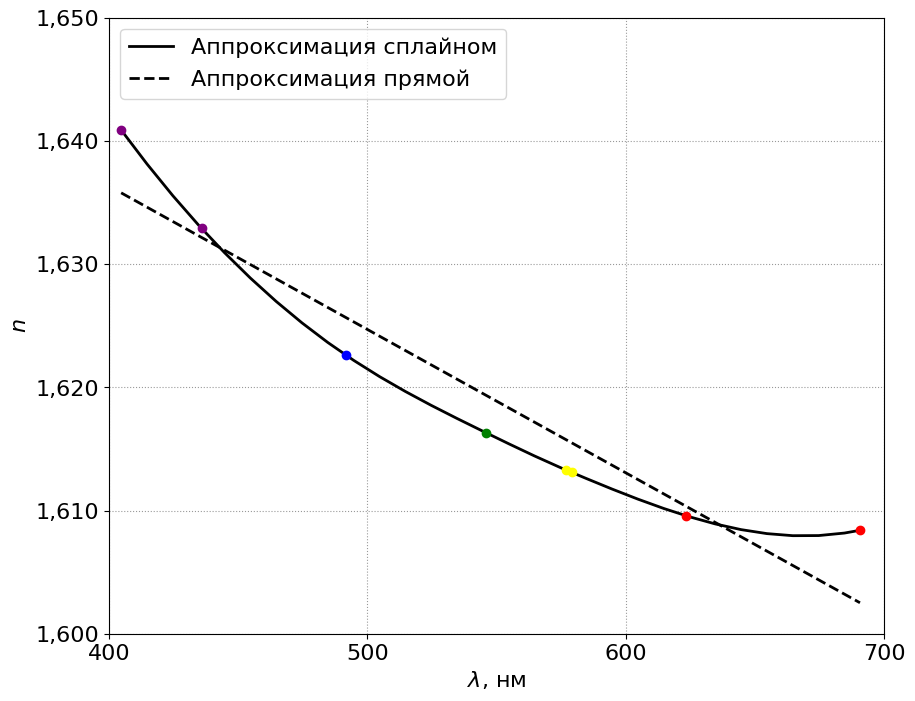

In [42]:
xMin = 400
xMax = 700.01

yMin = 1.600
yMax = 1.65001

xLabel          = r'$\lambda$, нм'
yLabel          = r'$n$'

xMinorStep      = 0
xMajorStep      = 100

yMinorStep      = 0
yMajorStep      = 10e-3

xTickMultiplier = 1
yTickMultiplier = 1

xPrecision      = 0
yPrecision      = 3

# Построение графика.

mpl.rcParams['font.size'] = 16

fig  = plt.figure(figsize = (10,8), dpi = 100)
axes = fig.add_subplot()

fig.set_facecolor("white")

# Заголовок

plt.xlabel(xLabel)
plt.ylabel(yLabel)

# Линии
for st in range(0, len(n)):
    plt.errorbar(lambdas[st], n[st], yerr = 0, xerr = 0, fmt = 'o', linewidth = 3, color = colors[st])

_x = np.array(list(np.arange(lambdas[0], lambdas[-1], 10)) + [lambdas[-1]])
plt.plot(_x, interp1(_x), '-', linewidth = 2, color = 'black', label = r'Аппроксимация сплайном')
plt.plot(_x, Line(_x, *popt1), '--', linewidth = 2, color = 'black', label = r'Аппроксимация прямой')

# Оформление масштабных чёрточек

if yMajorStep > 0:
    y_major_ticks = np.arange(yMin, yMax, yMajorStep)
    axes.set_yticks(y_major_ticks)

if yMinorStep > 0:
    y_minor_ticks = np.arange(yMin, yMax, yMinorStep)
    axes.set_yticks(y_minor_ticks, minor = True)

if xMajorStep > 0:
    x_major_ticks = np.arange(xMin, xMax, xMajorStep)
    axes.set_xticks(x_major_ticks)

if xMinorStep > 0:
    x_minor_ticks = np.arange(xMin, xMax, xMinorStep)
    axes.set_xticks(x_minor_ticks, minor = True)

# Пределы графика

plt.xlim([xMin, xMax])
plt.ylim([yMin, yMax])

# Форматирование чёрточек

def xTickFormatter(tickVal, position):
    return "{:.{prec}f}".format(tickVal * xTickMultiplier, prec = xPrecision).replace('.', ',')

def yTickFormatter(tickVal, position):
    return "{:.{prec}f}".format(tickVal * yTickMultiplier, prec = yPrecision).replace('.', ',')

axes.xaxis.set_major_formatter(ticker.FuncFormatter(xTickFormatter))
axes.yaxis.set_major_formatter(ticker.FuncFormatter(yTickFormatter))

# Легенда
plt.legend(loc = 'upper left')

# Сетка
plt.grid(which='major', linestyle = ':', c = 'black', alpha = 0.4)
plt.grid(which='minor', linestyle = ':', c = 'black', alpha = 0.1)

# Вывод
plt.savefig("Графики/n(lambda).png")
plt.show()